In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lasyasreeb21ai033","key":"b23c258b91d1d2cd94272e1f48f59bf9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown


In [ ]:
!unzip -q plantdisease.zip -d plant_disease

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# WITHOUT EDGE DETECTION

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 15
EPOCHS = 10

DATASET_PATH = 'plant_disease/PlantVillage'

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=15
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [ ]:
from tensorflow.keras import layers, models, Input

def attention_block(inputs):
    channels = inputs.shape[-1]

    attention = layers.GlobalAveragePooling2D()(inputs)
    attention = layers.Dense(channels // 4, activation='relu')(attention)
    attention = layers.Dense(channels, activation='sigmoid')(attention)
    attention = layers.Reshape((1, 1, channels))(attention)

    return layers.Multiply()([inputs, attention])

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_block(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_block(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_block(x)

    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_block(x)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_model((*IMAGE_SIZE, 3), NUM_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ max_pooling2d[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8)              │            264 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │            288 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 32)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 64, 64, 32)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ max_pooling2d_1[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │          1,040 │ global_average_poolin… │
├──────────────────────

 Total params: 469,287 (1.79 MB)

 Trainable params: 468,327 (1.79 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 141s 243ms/step - accuracy: 0.5073 - loss: 1.5380 - val_accuracy: 0.3423 - val_loss: 2.7396
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 113s 218ms/step - accuracy: 0.7680 - loss: 0.7167 - val_accuracy: 0.6279 - val_loss: 1.3839
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 113s 219ms/step - accuracy: 0.8585 - loss: 0.4421 - val_accuracy: 0.5653 - val_loss: 1.6319
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 112s 216ms/step - accuracy: 0.8881 - loss: 0.3494 - val_accuracy: 0.6084 - val_loss: 1.8851
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 142s 216ms/step - accuracy: 0.9020 - loss: 0.2955 - val_accuracy: 0.8246 - val_loss: 0.5160
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 132s 256ms/step - accuracy: 0.9282 - loss: 0.2286 - val_accuracy: 0.9139 - val_loss: 0.2584
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 112s 216ms/step - accuracy: 0.9326 - loss: 0.2153 - val_accuracy: 0.7712 - val_loss: 1.0013
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 144s 221ms/step - accuracy: 0.9399 -

In [ ]:
loss, accuracy = model.evaluate(val_gen)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.8994 - loss: 0.2896
Validation Accuracy: 89.81%


In [ ]:
model.save("plant_disease_model.h5")
from google.colab import files
files.download("plant_disease_model.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/plant_disease_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


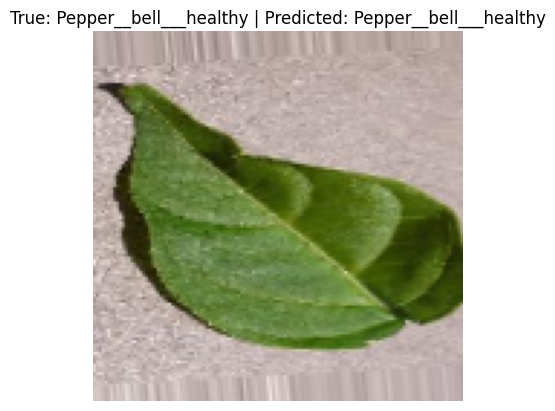

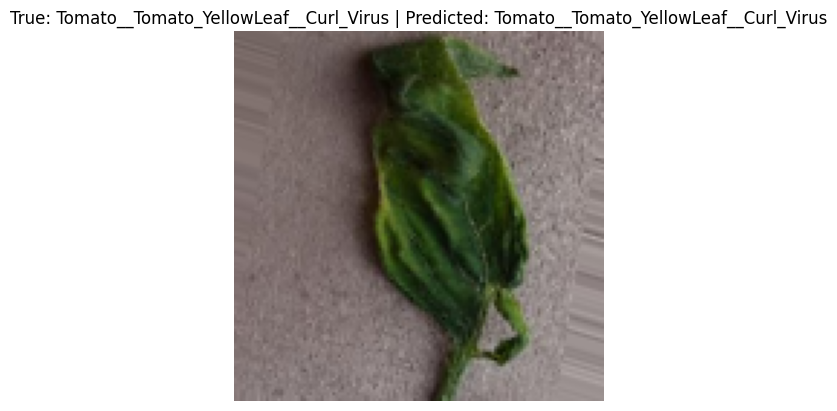

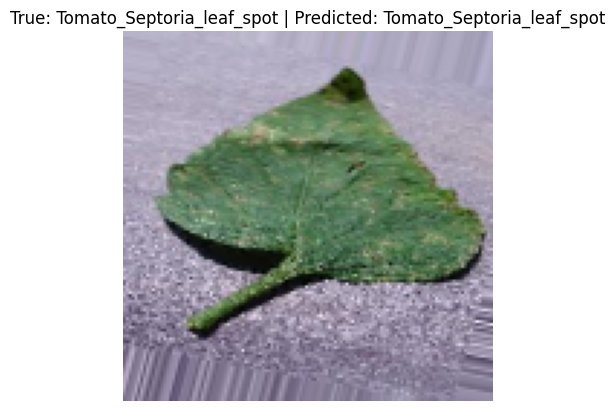

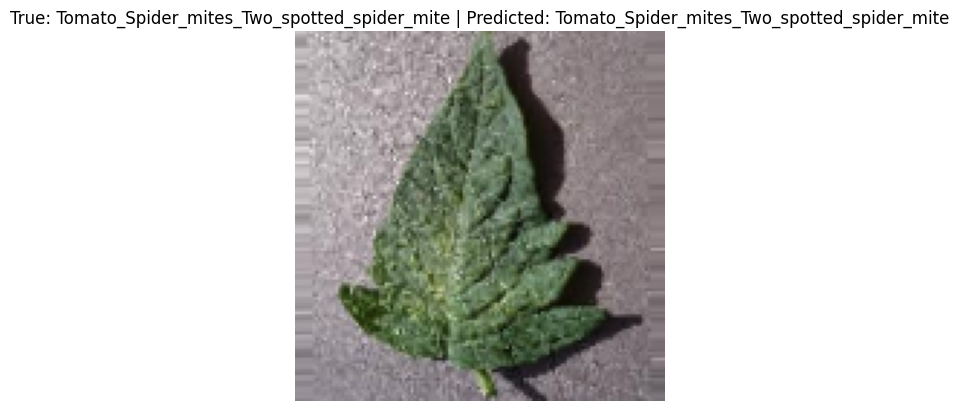

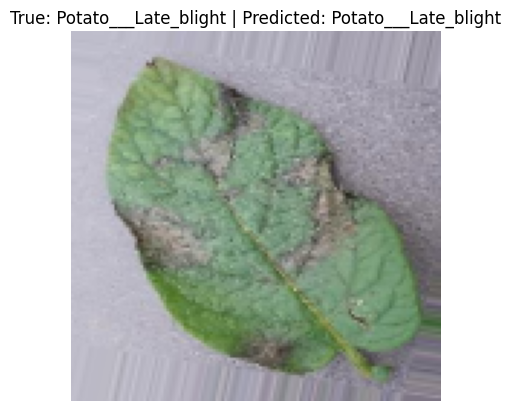

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_batch, y_batch = next(val_gen)

predictions = model.predict(x_batch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_batch, axis=1)
class_labels = list(train_gen.class_indices.keys())

for i in range(5):
    plt.imshow(x_batch[i])
    plt.title(f"True: {class_labels[true_classes[i]]} | Predicted: {class_labels[predicted_classes[i]]}")
    plt.axis('off')
    plt.show()


# WITH EDGE DETECTION

In [ ]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 15
EPOCHS = 15

DATASET_PATH = 'plant_disease/PlantVillage'

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=15
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [ ]:
def apply_edge_detection(image_batch):
    edged_images = []
    for img in image_batch:
        img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(img_gray, threshold1=100, threshold2=200)
        edges_rgb = np.stack((edges,) * 3, axis=-1) / 255.0
        edged_images.append(edges_rgb)
    return np.array(edged_images)

In [ ]:
def attention_block(inputs):
    channels = inputs.shape[-1]
    attention = layers.GlobalAveragePooling2D()(inputs)
    attention = layers.Dense(channels // 4, activation='relu')(attention)
    attention = layers.Dense(channels, activation='sigmoid')(attention)
    attention = layers.Reshape((1, 1, channels))(attention)
    return layers.Multiply()([inputs, attention])

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_block(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_block(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_block(x)

    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_block(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_model((*IMAGE_SIZE, 3), NUM_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ activation_4[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_4[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 8)         │        264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │        288 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 32)  │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 64, 64,    │          0 │ max_pooling2d_4[… │
│ (Multiply)          │ 32)               │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     18,496 │ multiply_4[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_5[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 16)        │      1,040 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      1,088 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 1, 64)  │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 32, 32,    │          0 │ max_pooling2d_5[

 Total params: 469,287 (1.79 MB)

 Trainable params: 468,327 (1.79 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS
)

Epoch 1/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 109s 190ms/step - accuracy: 0.5056 - loss: 1.5570 - val_accuracy: 0.2521 - val_loss: 2.8902
Epoch 2/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 95s 183ms/step - accuracy: 0.7755 - loss: 0.6838 - val_accuracy: 0.5206 - val_loss: 1.7972
Epoch 3/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 97s 187ms/step - accuracy: 0.8529 - loss: 0.4615 - val_accuracy: 0.6507 - val_loss: 1.1554
Epoch 4/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 96s 185ms/step - accuracy: 0.8807 - loss: 0.3719 - val_accuracy: 0.3971 - val_loss: 3.4087
Epoch 5/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 91s 176ms/step - accuracy: 0.9037 - loss: 0.3128 - val_accuracy: 0.5902 - val_loss: 1.9575
Epoch 6/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 93s 179ms/step - accuracy: 0.9146 - loss: 0.2622 - val_accuracy: 0.7363 - val_loss: 0.9142
Epoch 7/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 95s 184ms/step - accuracy: 0.9295 - loss: 0.2187 - val_accuracy: 0.9377 - val_loss: 0.1858
Epoch 8/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 139s 179ms/step - accuracy: 0.9382 - loss:

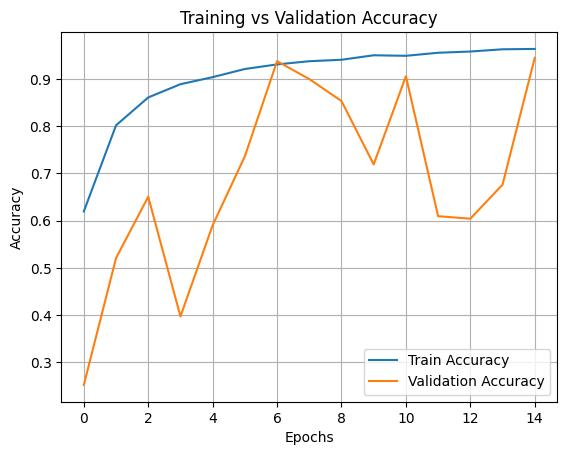

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(valid_gen)

129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.9514 - loss: 0.1552


In [ ]:
model.save("plant_disease_model.h5")

In [ ]:
from google.colab import files
files.download("plant_disease_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


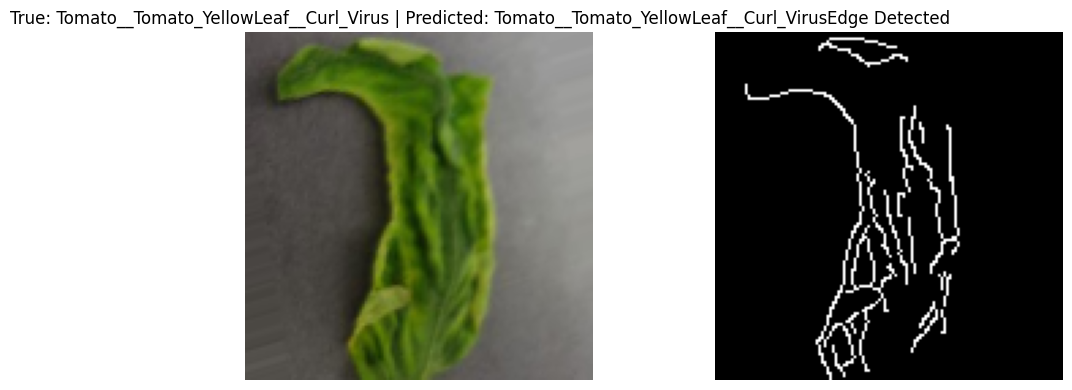

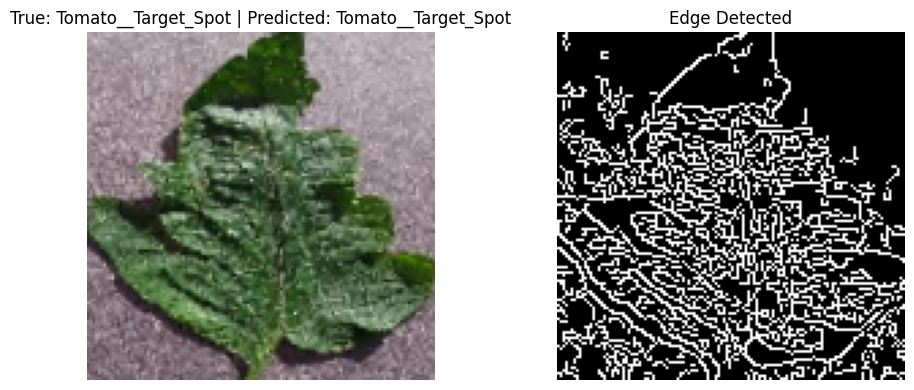

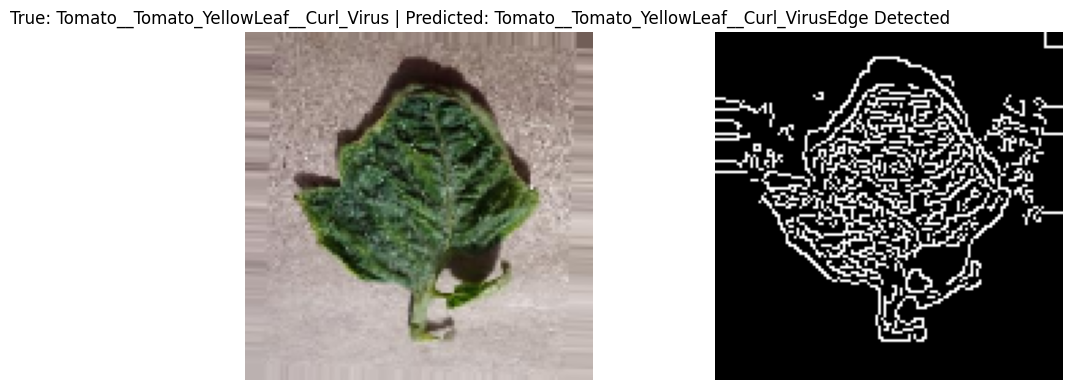

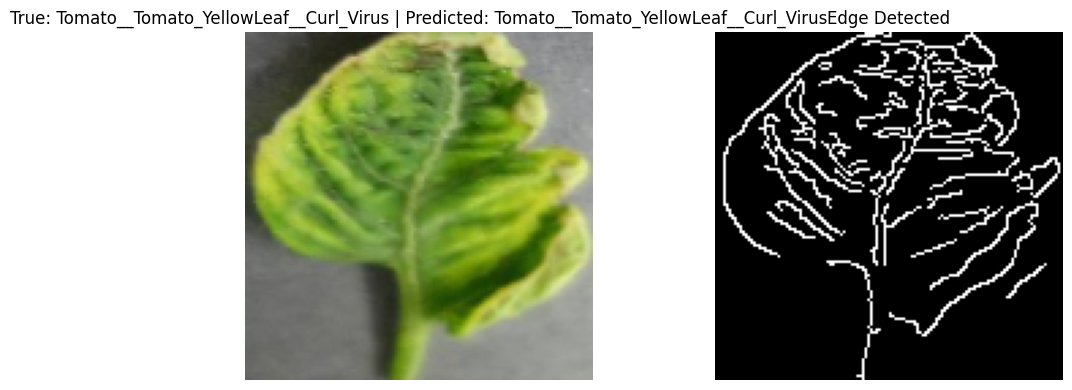

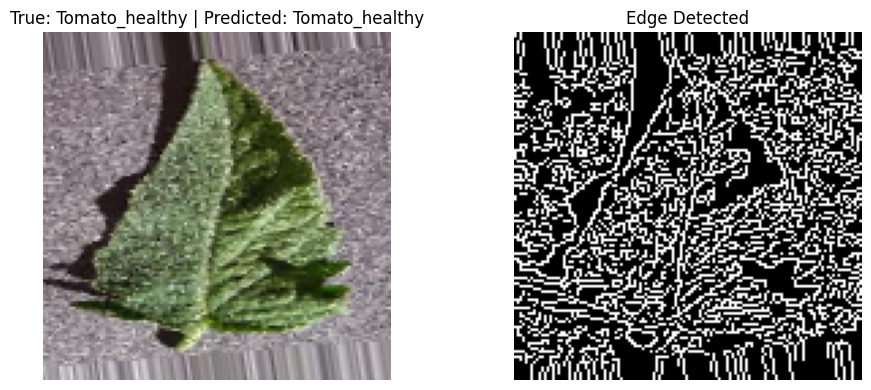

In [ ]:
valid_gen.batch_index = random.randint(0, len(valid_gen) - 1)
x_batch, y_batch = next(valid_gen)
predictions = model.predict(x_batch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_batch, axis=1)
class_labels = list(train_gen.class_indices.keys())

for i in range(5):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(x_batch[i])
    plt.title(f"True: {class_labels[true_classes[i]]} | Predicted: {class_labels[predicted_classes[i]]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    edge_img = apply_edge_detection(x_batch[[i]])[0]
    plt.imshow(edge_img)
    plt.title("Edge Detected")
    plt.axis('off')

    plt.tight_layout()
    plt.show()